[Pasta no Drive com o dataset e notebook para usar no colab](https://drive.google.com/drive/folders/1LfruASfUfg9UaMu__-UGoOyOEkDAXKLO?usp=sharing)

## Encontro de Aprendizado de Máquina

## 1) Problema a ser resolvido

### Descrição
O problema a ser resolvido consiste na identificação da presença, ou não, de doenças respiratórias em pessoas,
através da análise de áudios que registram sua respiração. 

De acordo com [Respiratory Sound Database](https://www.kaggle.com/vbookshelf/respiratory-sound-database), o som que é
emitido quando uma pessoa respira está diretamente relacionado com o movimento do ar,
as condições do tecido pulmonar e a existência ou não de secreções dentro do pulmão.


### Datasets a serem utilizados
Utilizaremos o dataset disponível em [Respiratory Sound Database](https://www.kaggle.com/vbookshelf/respiratory-sound-database).

Esse dataset inclui 920 anotações de áudios, de
tamanhos variáveis entre 10s e 90s. Essas gravações foram obtidas a partir de 126
pacientes diferentes, contendo 6898 ciclos respiratórios, dos quais 1864 contêm
crepitações, 886 contêm chiados e 506 contêm tanto crepitações quanto chiados. 

Além disso,
o dataset é composto tanto por áudios limpos como por áudios com ruídos. E existem
pacientes de todas as faixas etárias: crianças, adultos e idosos.

### Features
#### a) Pacientes:
**Dados demográficos:** número do paciente, idade, sexo, IMC do adulto
(kg/m2), peso da criança (kg), altura da criança (cm).

#### b) Áudios:
**numero do paciente**<br>
**Índice de gravação**<br>
**Localização no peito:** trachea (Tc), anterior left (Al), anterior right (Ar),
posterior left (Pl), posterior right (Pr), lateral left (Ll), lateral right (Lr).<br>
**Modo de aquisição:** sequential/single channel (sc),
simultaneous/multichannel (mc).<br>
**Equipamento de gravação:** AKG C417L Microphone (AKGC417L), 3M
Littmann Classic II SE Stethoscope (LittC2SE), 3M Litmmann 3200 Electronic
Stethoscope (Litt3200), WelchAllyn Meditron Master Elite Electronic
Stethoscope (Meditron).

#### Ex: 107_2b4_Pr_mc_AKGC417L

#### c) Anotações:
Início do ciclo respiratório(s), Fim do ciclo respiratório(s), Presença/Ausência
de crepitações (presence=1, absence=0), Presença/Ausência de sibilos
(presence=1, absence=0).

**Este trabalho utiliza trechos de código disponibilizados em:** 

[Classificação Áudio](https://github.com/seth814/Audio-Classification/blob/master/eda.py)

[Classification of Music into different Genres using Keras](https://medium.com/@sdoshi579/classification-of-music-into-different-genres-using-keras-82ab5339efe0)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 2) Importar Bibliotecas

In [ ]:
%matplotlib inline
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa #pip install librosa
from tqdm import tqdm
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import librosa.display

Para a análise dos dados de áudio, utilizaremos a biblioteca [Librosa](https://librosa.github.io/librosa/index.html).

## 3) Preparar conjunto de dados

In [ ]:
ROOT_PATH = '/content/drive/My Drive/01-Encontro_ML_2019/' # 1- Sua vez :) Coloque seu path para o local em que seu dataset está.

### Passo 01: Criar *filenames*

Os nomes dos arquivos de áudio são compostos por:

**nº do paciente + índice de gravação + localização do microfone + modo de aquisição + equipamento de gravação**

Essas informações serão armazenadas na lista **filenames**.

In [ ]:
PATH = ROOT_PATH + 'audio_and_txt_files'

filenames = [s.split('.')[0] for s in os.listdir(path = PATH) if '.txt' in s]


In [5]:
filenames[:5]

['179_1b1_Tc_sc_Meditron',
 '222_1b1_Pr_sc_Meditron',
 '178_2b2_Pr_mc_AKGC417L',
 '218_1p1_Pr_sc_Litt3200',
 '146_2b2_Pl_mc_AKGC417L']

### Passo 02: Identificar *labels*

As *labels* do conjunto de dados consistem nos diagnósticos dos pacientes. Elas estão no arquivo **patient_diagnosis.csv**, juntamente com o número do paciente a quem o diagnóstico pertence.

In [ ]:
PATH = ROOT_PATH + 'dataset/patient_diagnosis.csv'

classes = pd.read_csv(PATH, names = ['patient_number','diagnosis'])


In [7]:
classes.head()

,patient_number,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


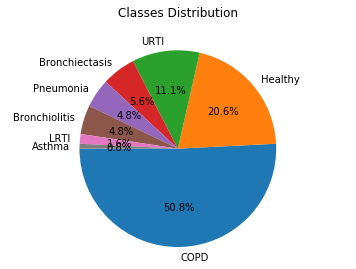

In [8]:
classes_dist = classes['diagnosis'].value_counts()
fig, ax = plt.subplots()
ax.set_title('Classes Distribution', y=1.08)
ax.pie(classes_dist, labels=classes_dist.index, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.show()

### Passo 03: Transformar *labels* de valor categórico para numérico

Esse conjunto de dados possui uma *label* para cada tipo de problema respiratório que um paciente possui. Entretanto, não queremos determinar o tipo de problema respiratório, mas apenas se o paciente possui ou não algum deles. 

Dessa forma, mapearemos as *labels* em que o paciente é saudável para 1 (*Healthy*) e o restante para -1.

In [ ]:
# 2 - Vamos tentar? Temos que mapear as labels :)
classes['diagnosis'] = np.where(classes['diagnosis'] == 'Healthy', 1, -1)

In [10]:
classes.head()

,patient_number,diagnosis
0,101,-1
1,102,1
2,103,-1
3,104,-1
4,105,-1


### Passo 04: Redistribuir os dados

Tentaremos pegar uma quantidade igual de pacientes saudáveis e não saudáveis do conjunto de dados.

In [11]:
classes['diagnosis'].value_counts()

-1    100
 1     26
Name: diagnosis, dtype: int64

In [ ]:
#Pegamos a quantidade de pacientes saudáveis
amount_h = classes['diagnosis'].value_counts()[1]

In [ ]:
# 3 - Mais um desafio :) Vamos separar pacientes saudáveis e não saudáveis. É importante usar
# os mesmos nomes da célula abaixo.
healthy_pacients = classes[classes['diagnosis'] == 1]
unhealthy_pacients = classes[classes['diagnosis'] == -1]

In [14]:
healthy_pacients.shape, unhealthy_pacients.shape

((26, 2), (100, 2))

In [ ]:
# 4 - Oi :) Agora temos que pegar apenas os amount_h primeiros pacientes não saudáveis e salvá-los
#na variável com o mesmo nome da célula abaixo.

unhealthy_pacients = unhealthy_pacients.head(amount_h)

In [16]:
unhealthy_pacients.head()

,patient_number,diagnosis
0,101,-1
2,103,-1
3,104,-1
4,105,-1
5,106,-1


In [ ]:
# 5 - Novamente :) Agora, precisamos juntar os pacientes saudáveis e não saudáveis no mesmo dataframe "patients".

patients = pd.concat([healthy_pacients, unhealthy_pacients], join='inner').sort_values(by='patient_number')

In [18]:
patients.head()

,patient_number,diagnosis
0,101,-1
1,102,1
2,103,-1
3,104,-1
4,105,-1


In [19]:
patients['diagnosis'].value_counts()

 1    26
-1    26
Name: diagnosis, dtype: int64

### Passo 05: Ler arquivos de áudio

Leremos apenas os arquivos de áudio dos pacientes que selecionamos no passo anterior.

In [ ]:
#Essa função retorna os valores numéricos do áudio, a taxa de amostragem e a duração em segundos
def getAudioInfo(audio):
    signal, rate = librosa.load(audio)
    
    # 6 - Agora trabalharemos com áudios :) Precisamos calcular a duração do áudio que recebemos na função.
    duration = [signal.shape[0]/rate]
    
    return signal, rate, duration

In [ ]:
#Dicionários para armazenar as informações que queremos

dict_audio_signals = {}
dict_audio_rates = {}
dict_audio_durations = {}
dict_filename_label = {}

In [25]:
filenames[:5]

['179_1b1_Tc_sc_Meditron',
 '222_1b1_Pr_sc_Meditron',
 '178_2b2_Pr_mc_AKGC417L',
 '218_1p1_Pr_sc_Litt3200',
 '146_2b2_Pl_mc_AKGC417L']

In [26]:
# Ela também cria um dicionário que mapeia o nome do áudio com a label do paciente a quem ele pertence

PATH=ROOT_PATH + 'audio_and_txt_files/'

for f in tqdm(filenames):
    number = f.split('_')[0]
   
    if(int(number) in patients['patient_number'].values):
        dict_audio_signals[f], dict_audio_rates[f], dict_audio_durations[f] = getAudioInfo(PATH + f + '.wav')
        dict_filename_label[f] = patients[patients['patient_number'] == int(number)].values[0,1]
        patients = patients[patients['patient_number'].values != int(number)]

100%|██████████| 920/920 [01:31<00:00, 10.05it/s]


In [27]:
for key in dict_filename_label:
  print("{} : {}".format(key, dict_filename_label[key]))

179_1b1_Tc_sc_Meditron : 1
113_1b1_Pl_sc_Litt3200 : -1
130_2p5_Pl_mc_AKGC417L : -1
124_1b1_Pl_sc_Litt3200 : -1
128_1b3_Tc_mc_LittC2SE : -1
104_1b1_Pl_sc_Litt3200 : -1
107_2b4_Al_mc_AKGC417L : -1
122_2b3_Tc_mc_LittC2SE : -1
115_1b1_Ar_sc_Meditron : -1
194_1b1_Lr_sc_Meditron : 1
118_1b1_Lr_sc_Litt3200 : -1
120_1b1_Pl_sc_Meditron : -1
109_1b1_Lr_sc_Litt3200 : -1
126_1b1_Al_sc_Meditron : 1
136_1b1_Ar_sc_Meditron : 1
110_1p1_Pr_sc_Meditron : -1
183_1b1_Tc_sc_Meditron : 1
112_1p1_Pl_sc_Litt3200 : -1
208_1b1_Ll_sc_Meditron : 1
114_1b4_Lr_mc_AKGC417L : -1
111_1b2_Tc_sc_Meditron : -1
159_1b1_Ll_sc_Meditron : 1
224_1b1_Tc_sc_Meditron : 1
184_1b1_Ar_sc_Meditron : 1
144_1b1_Tc_sc_Meditron : 1
131_1b1_Al_sc_Meditron : -1
171_1b1_Al_sc_Meditron : 1
116_1b2_Tc_sc_Meditron : -1
129_1b1_Ar_sc_Meditron : -1
121_1p1_Tc_sc_Meditron : 1
225_1b1_Pl_sc_Meditron : 1
101_1b1_Pr_sc_Meditron : -1
217_1b1_Tc_sc_Meditron : 1
102_1b1_Ar_sc_Meditron : 1
187_1b1_Ll_sc_Meditron : 1
214_1b1_Ar_sc_Meditron : 1
117_1b3_T

In [ ]:
#Função auxiliar para a plotagem dos gráficos de áudio
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

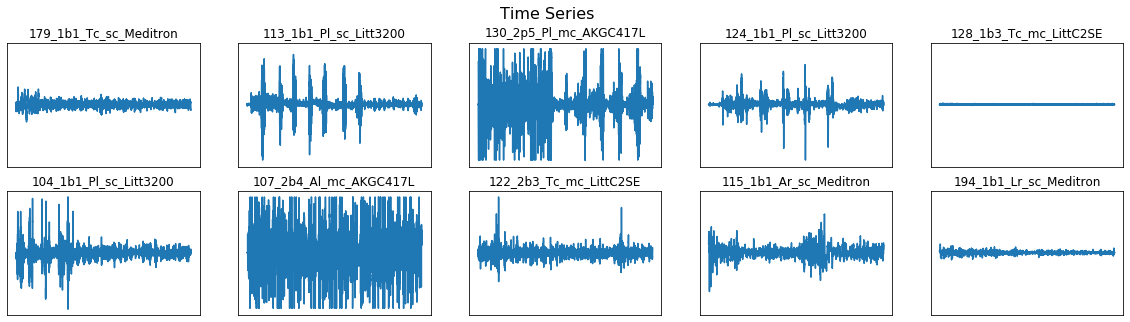

In [29]:
plot_signals(dict_audio_signals)

### Passo 08: Criar conjunto de dados com as *features* extraídas

Neste passo, extrairemos as *features* de cada áudio e as salvaremos em um arquivo .csv.

As *features* a serem extraídas são:


#### STFT (Short Term Fourier Transform):
É uma aplicação da Transformada de Fourier para espectros que variam com o tempo, nos permitindo relacionar frequência e tempo.

#### RMSE (Root Mean Square Energy):
Calcula a raiz quadrada média da energia contida em um sinal de áudio.

#### Centroide Espectral:
Indica o "centro de massa" do áudio, calculando a média ponderada das frequências presentes nele.

#### Rolloff:
É a frequência abaixo da qual uma determinada porcentagem da energia espectral se localiza.

#### Taxa de Zero Crossing:
É a taxa na qual o sinal muda seu valor de positivo para negativo, e vice-versa.

#### MFCC (Mel-Frequency Cepstral Coefficients):
É um conjunto pequeno de características utilizado para descrever o envelope sonoro. O MFCC é uma das features mais amplamente utilizadas para processamento de áudio.

Uma explicação mais detalhada das features pode ser encontrada em [Music Features Extraction](https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d), [STFT](https://pt.wikipedia.org/wiki/Transformada_de_Fourier_de_curto_termo) e [RMSE](https://librosa.github.io/librosa/0.6.0/generated/librosa.feature.rmse.html).

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'

for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
file = open(ROOT_PATH + 'datafinal.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [ ]:
for key in tqdm(dict_audio_signals):
    chroma_stft = librosa.amplitude_to_db(np.abs(librosa.stft(y=dict_audio_signals[key])))
    rmse = librosa.feature.rmse(y=dict_audio_signals[key])
    spec_cent = librosa.feature.spectral_centroid(y=dict_audio_signals[key], sr=dict_audio_rates[key])
    spec_bw = librosa.feature.spectral_bandwidth(y=dict_audio_signals[key], sr=dict_audio_rates[key])
    rolloff = librosa.feature.spectral_rolloff(y=dict_audio_signals[key], sr=dict_audio_rates[key])
    zcr = librosa.feature.zero_crossing_rate(dict_audio_signals[key])
    mfcc = librosa.feature.mfcc(y=dict_audio_signals[key], sr=dict_audio_rates[key])

    to_append = f'{key} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'

    for e in mfcc:
        to_append += f' {np.mean(e)}'

    to_append += f' {dict_filename_label[key]}'
    file = open(ROOT_PATH + '/datafinal.csv', 'a', newline='')
    with file:
    writer = csv.writer(file)
    writer.writerow(to_append.split())

## 4) Breve Análise dos Dados

### Passo 01: Ler conjunto de dados

Agora, leremos as informações sobre os áudios, que estão salvas no arquivo **datafinal.csv**. Esse arquivo contém as *features* e os *labels* do conjunto de dados considerado.

In [ ]:
data = pd.read_csv(ROOT_PATH + 'datafinal.csv')

In [ ]:
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,107_2b4_Pr_mc_AKGC417L,-17.938953,0.412915,433.436041,1348.680562,352.475053,0.005968,-243.142066,135.449303,61.997014,45.659463,22.972295,18.716659,9.678623,10.696918,7.425557,10.237305,7.522652,9.883407,6.117369,7.523315,4.129134,5.851761,3.073761,4.703141,2.076042,3.625250,-1
1,179_1b1_Tc_sc_Meditron,-31.814646,0.051774,883.186376,2413.645032,1062.383792,0.010107,-498.754147,76.143643,55.564120,3.099266,32.182653,20.346869,25.803801,8.482742,18.637764,14.141950,17.027479,8.632240,14.284937,9.528540,13.600491,3.499131,11.125027,2.594493,6.537717,6.330375,1
2,113_1b1_Pl_sc_Litt3200,-24.140705,0.068945,75.985290,126.943706,131.833600,0.003876,-445.896263,70.209540,55.678279,39.060750,25.730073,17.312751,12.911670,11.465329,12.423868,14.908526,17.343015,18.297556,17.372483,15.044855,11.924791,8.462330,5.209411,2.890813,1.966197,2.251578,-1
3,130_2p5_Pl_mc_AKGC417L,-20.222477,0.242368,348.533169,1073.041974,429.390056,0.004606,-347.488180,103.701610,61.265503,40.421146,30.945685,20.517219,16.892888,17.903932,14.436799,11.056963,12.066593,11.490982,7.774761,6.456328,6.848995,5.435458,4.109769,4.120025,3.290146,2.697908,-1
4,124_1b1_Pl_sc_Litt3200,-28.213728,0.064149,109.643262,159.708769,199.012679,0.005670,-416.029149,76.620055,60.133699,40.166350,22.970751,11.762580,6.750611,6.577388,9.345919,12.975202,15.642485,16.432506,15.495186,13.440842,10.687371,7.486051,4.361705,2.138256,1.353842,1.773721,-1


### Passo 02: Observar informações

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 28 columns):
filename              52 non-null object
chroma_stft           52 non-null float64
rmse                  52 non-null float64
spectral_centroid     52 non-null float64
spectral_bandwidth    52 non-null float64
rolloff               52 non-null float64
zero_crossing_rate    52 non-null float64
mfcc1                 52 non-null float64
mfcc2                 52 non-null float64
mfcc3                 52 non-null float64
mfcc4                 52 non-null float64
mfcc5                 52 non-null float64
mfcc6                 52 non-null float64
mfcc7                 52 non-null float64
mfcc8                 52 non-null float64
mfcc9                 52 non-null float64
mfcc10                52 non-null float64
mfcc11                52 non-null float64
mfcc12                52 non-null float64
mfcc13                52 non-null float64
mfcc14                52 non-null float64
mfcc15          

In [ ]:
data['label'].value_counts()

 1    26
-1    26
Name: label, dtype: int64

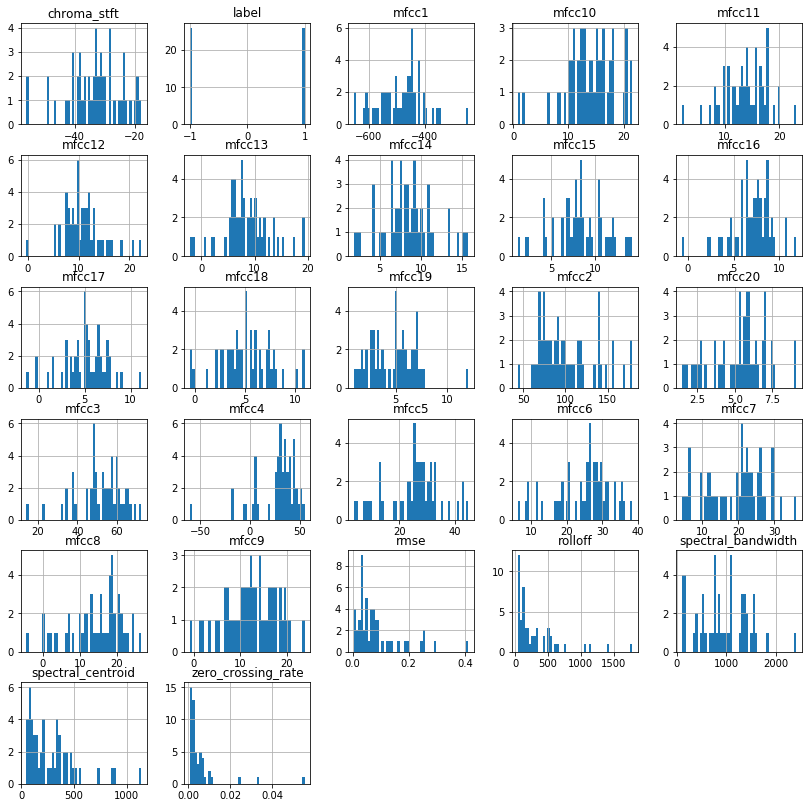

In [ ]:
data.hist(bins=50, figsize=(14,14))
plt.show()

In [ ]:
data.corr().style.background_gradient(cmap='RdYlGn')

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
chroma_stft,1,0.769644,-0.449722,-0.497114,-0.35637,-0.232169,0.850808,-0.471872,0.253285,0.258818,0.411928,0.156267,0.168986,0.181732,0.278797,0.17233,0.223253,0.332405,0.318389,0.135692,0.11379,-0.00849627,0.376959,-0.0394243,0.183764,-0.14542,-0.134523
rmse,0.769644,1,-0.339833,-0.334096,-0.307623,-0.242141,0.728309,-0.268133,0.238232,0.314918,0.307256,0.125947,0.137452,0.262232,0.272035,0.140856,0.00944034,0.164304,0.114329,0.0502886,-0.0698641,-0.00444758,0.252182,0.179424,0.215128,-0.0510553,-0.21553
spectral_centroid,-0.449722,-0.339833,1,0.872704,0.919322,0.78562,-0.139342,0.674739,-0.583392,-0.733969,-0.55886,-0.272842,-0.325433,-0.509061,-0.4743,-0.393257,-0.371276,-0.449446,-0.3535,-0.345994,-0.273562,-0.422664,-0.288276,-0.175067,-0.179204,0.248275,0.0445435
spectral_bandwidth,-0.497114,-0.334096,0.872704,1,0.630811,0.428015,-0.338895,0.467042,-0.42557,-0.478052,-0.338138,-0.0803663,-0.0708917,-0.204603,-0.279935,-0.376095,-0.406937,-0.533988,-0.38049,-0.408366,-0.289778,-0.233799,-0.148019,0.0487486,-0.0239157,0.373338,0.279629
rolloff,-0.35637,-0.307623,0.919322,0.630811,1,0.909729,0.0199513,0.751218,-0.615832,-0.839134,-0.637118,-0.324357,-0.434661,-0.676141,-0.540258,-0.295749,-0.247307,-0.383895,-0.361848,-0.266094,-0.148215,-0.474682,-0.363114,-0.340928,-0.249085,0.135379,-0.102067
zero_crossing_rate,-0.232169,-0.242141,0.78562,0.428015,0.909729,1,0.116532,0.649882,-0.574242,-0.782957,-0.529465,-0.282479,-0.388512,-0.596434,-0.50574,-0.343515,-0.324298,-0.239195,-0.231665,-0.214852,-0.241109,-0.525281,-0.280168,-0.355751,-0.21206,0.101254,-0.206371
mfcc1,0.850808,0.728309,-0.139342,-0.338895,0.0199513,0.116532,1,-0.0435992,0.0321634,-0.0577018,0.0481652,-0.0854007,-0.181947,-0.207984,-0.0530081,0.0840437,0.168495,0.255297,0.138026,0.0950888,0.0634834,-0.163006,0.0679034,-0.258965,-0.0592955,-0.240625,-0.194316
mfcc2,-0.471872,-0.268133,0.674739,0.467042,0.751218,0.649882,-0.0435992,1,-0.520692,-0.758519,-0.787128,-0.244471,-0.436295,-0.665427,-0.69676,-0.240469,-0.193347,-0.451118,-0.629903,-0.321561,-0.148313,-0.243165,-0.616637,-0.301524,-0.325404,0.0508952,-0.0250658
mfcc3,0.253285,0.238232,-0.583392,-0.42557,-0.615832,-0.574242,0.0321634,-0.520692,1,0.729841,0.45041,-0.170133,0.0322957,0.363095,0.469558,0.233163,0.176088,0.388968,0.417215,0.218955,-0.0319986,0.0327919,0.106768,-0.1201,-0.0921768,-0.303258,-0.139006
mfcc4,0.258818,0.314918,-0.733969,-0.478052,-0.839134,-0.782957,-0.0577018,-0.758519,0.729841,1,0.706797,0.0986895,0.233429,0.65245,0.57582,0.21706,0.106706,0.417143,0.427431,0.186458,-0.0553181,0.254732,0.28998,0.257233,0.0513425,-0.237595,-0.0613004


## 4) Aplicando Modelos de Aprendizado

### Passo 01: Fazer preprocessamento dos dados

In [ ]:
# Retirar colunas desnecessárias
data = data.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,-17.938953,0.412915,433.436041,1348.680562,352.475053,0.005968,-243.142066,135.449303,61.997014,45.659463,22.972295,18.716659,9.678623,10.696918,7.425557,10.237305,7.522652,9.883407,6.117369,7.523315,4.129134,5.851761,3.073761,4.703141,2.076042,3.625250,-1
1,-31.814646,0.051774,883.186376,2413.645032,1062.383792,0.010107,-498.754147,76.143643,55.564120,3.099266,32.182653,20.346869,25.803801,8.482742,18.637764,14.141950,17.027479,8.632240,14.284937,9.528540,13.600491,3.499131,11.125027,2.594493,6.537717,6.330375,1
2,-24.140705,0.068945,75.985290,126.943706,131.833600,0.003876,-445.896263,70.209540,55.678279,39.060750,25.730073,17.312751,12.911670,11.465329,12.423868,14.908526,17.343015,18.297556,17.372483,15.044855,11.924791,8.462330,5.209411,2.890813,1.966197,2.251578,-1
3,-20.222477,0.242368,348.533169,1073.041974,429.390056,0.004606,-347.488180,103.701610,61.265503,40.421146,30.945685,20.517219,16.892888,17.903932,14.436799,11.056963,12.066593,11.490982,7.774761,6.456328,6.848995,5.435458,4.109769,4.120025,3.290146,2.697908,-1
4,-28.213728,0.064149,109.643262,159.708769,199.012679,0.005670,-416.029149,76.620055,60.133699,40.166350,22.970751,11.762580,6.750611,6.577388,9.345919,12.975202,15.642485,16.432506,15.495186,13.440842,10.687371,7.486051,4.361705,2.138256,1.353842,1.773721,-1


### Passo 02: Capturar variáveis de entrada e saída

As variáveis de entrada são todas as *features* que extraímos dos áudios e a variável de saída é o *label* que diz se um paciente é saudável (1) ou não (-1).

In [ ]:
# 7 - Sua vez :) Precisamos separar dados de entrada e saída
X = '???'
y = '???'

### Passo 03: Separar conjunto de treino e de teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

((11, 26), (11,))

### Passo 04: Standardizar conjunto de dados

In [ ]:
# 8 - Vamos standardizar os dados? Podemos usar o StandardScaler()
ss = StandarScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


### Passo 05: Criar modelos de aprendizado

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score

In [ ]:
models = {}
y_pred = {}
acc = {}

In [ ]:
models['gnb'] = GaussianNB()
models['svm'] = SVC(gamma='scale')
models['knn'] = KNeighborsClassifier(n_neighbors=3)
models['sgd'] = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

In [ ]:
for key in models:
    models[key].fit(X_train, y_train)
    y_pred[key] = models[key].predict(X_test)
    acc[key] = accuracy_score(y_test, y_pred[key])

In [ ]:
for key in acc:
    print("Modelo:{} | ACC:{}".format(key, acc[key]))

Modelo:gnb | ACC:0.9090909090909091
Modelo:svm | ACC:0.9090909090909091
Modelo:knn | ACC:0.8181818181818182
Modelo:sgd | ACC:0.7272727272727273


**<center> Obrigada :) </center>**

Produzido por: Marianna de Pinho Severo